In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import numpy as np
import jax.numpy as jnp
import jax
import scipy.stats
import matplotlib.pyplot as plt

## Investigating Clopper-Pearson

In [2]:
%%time
n = 50
p = 0.2
thresh = 16
print("true type I error", 1 - scipy.stats.binom.cdf(thresh - 1, n, p))

niter = 1
ntests = 100000
nsims = 1000
delta = 0.01
test_ests = np.empty((niter, ntests))
n_failures = np.empty(niter, dtype=np.int32)
for i in range(niter):
    samples = scipy.stats.binom.rvs(n, p, size=nsims)
    reject = samples >= thresh
    typeI_sum = jnp.sum(reject)
    typeI_est = typeI_sum / nsims
    typeI_CI = (
        scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est
    )
    upper99 = typeI_est + typeI_CI

    test_ests[i, :] = jnp.mean(
        scipy.stats.binom.rvs(n, p, size=(ntests, nsims)) > thresh, axis=-1
    )
    n_failures[i] = jnp.sum(test_ests > upper99)

true type I error 0.03080342278204773
CPU times: user 7.03 s, sys: 368 ms, total: 7.4 s
Wall time: 7.33 s


In [3]:
empirical99 = np.percentile(test_ests.flatten(), 99)

In [4]:
empirical99

0.024000000208616257

In [5]:
nsims = 40000000
samples = scipy.stats.binom.rvs(n, p, size=nsims)
reject = samples >= thresh
typeI_sum = jnp.sum(reject)
typeI_est = typeI_sum / nsims
typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est
upper99_2 = typeI_est + typeI_CI

In [6]:
typeI_est, typeI_CI

(DeviceArray(0.03077822, dtype=float64),
 DeviceArray(6.35886319e-05, dtype=float64))

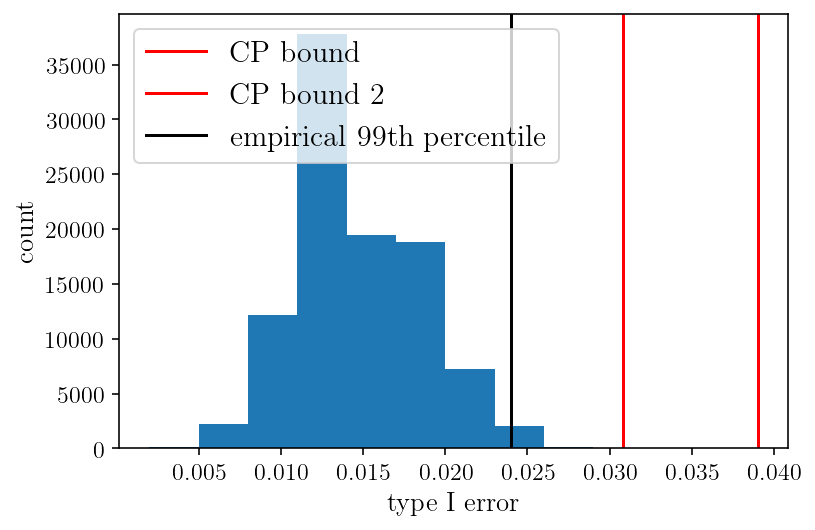

In [7]:
plt.hist(test_ests.flatten())
plt.axvline(upper99, color="r", label="CP bound")
plt.axvline(upper99_2, color="r", label="CP bound 2")
plt.axvline(empirical99, color="k", label="empirical 99th percentile")
plt.xlabel("type I error")
plt.ylabel("count")
plt.legend()
plt.show()

In [8]:
typeI_sum

DeviceArray(1231129, dtype=int64)

In [9]:
(n_failures.sum() / (niter * ntests))

0.0

## Check gradient bound

In [10]:
n = 50
p = 0.2
t = jax.scipy.special.logit(p)
At = lambda t: -n * jnp.log(1 - jax.scipy.special.expit(t))
g = lambda t, x: t * x - At(t)
dg = jax.grad(g)
dg_vmap = jax.vmap(dg, in_axes=(None, 0))

holderp = 1.2
holderq = 6.0
# holderq = 1.0 / (1 - 1.0 / holderp)

In [12]:
# numerical integral to compute E[ |grad g|^q]^(1/q)
# need to compute for the worst t in the "tile".
def C_numerical(t, p, holderq):
    xs = jnp.arange(n + 1).astype(jnp.float64)
    eggq = jnp.abs(dg_vmap(t, xs)) ** holderq
    return sum(eggq * scipy.stats.binom.pmf(xs, n, p)) ** (1 / holderq)


# Formula for C with q = 6 from wikipedia
def C_wiki(p):
    assert holderq == 6
    return (
        n
        * p
        * (1 - p)
        * (
            1
            - 30 * p * (1 - p) * (1 - 4 * p * (1 - p))
            + 5 * n * p * (1 - p) * (5 - 26 * p * (1 - p))
            + 15 * n**2 * p**2 * (1 - p) ** 2
        )
    ) ** (1 / 6)


# p = 0.2 corresponds to t=-1.386
# choose theta = -1.1 as the edge of our tile.
# so our tile is going to extend unidirectionally from -1.386 (the grid pt) to -1.1
# since the constant is monotonic in the relevant region, we can just compute
# at the edge of the tile to get a maximum value.
# tmax = -1.1
tmax = t
pmax = jax.scipy.special.expit(tmax)
C = C_wiki(pmax)
C_numerical(tmax, pmax, holderq), C_wiki(pmax)

(DeviceArray(4.46680721, dtype=float64),
 DeviceArray(4.46680721, dtype=float64, weak_type=True))

In [13]:
np.random.seed(0)
thresh = 20
nsims = 500000
print("true type I error", 1 - scipy.stats.binom.cdf(thresh - 1, n, p))
samples = scipy.stats.binom.rvs(n, p, size=nsims)
reject = samples >= thresh
typeI_sum = jnp.sum(reject)
typeI_est = typeI_sum / nsims
typeI_CI = scipy.stats.beta.ppf(1 - delta, typeI_sum + 1, nsims - typeI_sum) - typeI_est

grad_bound = []
for q in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    holderq = q
    holderp = 1.0 / (1 - 1.0 / holderq)
    print(holderq, holderp)
    C = C_numerical(tmax, pmax, holderq)
    grad_bound.append(C * (typeI_est + typeI_CI) ** (1 / holderp))
typeI_est + typeI_CI, grad_bound

true type I error 0.0009324364894210957
4 1.3333333333333333
5 1.25
6 1.2
7 1.1666666666666665
8 1.1428571428571428
9 1.125
10 1.1111111111111112
11 1.1
12 1.090909090909091
13 1.0833333333333333
14 1.0769230769230769
15 1.0714285714285714


(DeviceArray(0.00105638, dtype=float64),
 [DeviceArray(0.0218209, dtype=float64),
  DeviceArray(0.01708739, dtype=float64),
  DeviceArray(0.01478594, dtype=float64),
  DeviceArray(0.01351862, dtype=float64),
  DeviceArray(0.01277607, dtype=float64),
  DeviceArray(0.01233228, dtype=float64),
  DeviceArray(0.01207249, dtype=float64),
  DeviceArray(0.01193241, dtype=float64),
  DeviceArray(0.01187333, dtype=float64),
  DeviceArray(0.01187064, dtype=float64),
  DeviceArray(0.01190807, dtype=float64),
  DeviceArray(0.01197453, dtype=float64)])

In [14]:
ntests = 100
new_samples = scipy.stats.binom.rvs(n, p, size=(ntests, nsims))
grad_est = np.mean((new_samples >= thresh) * (new_samples - n * p), axis=-1)
np.percentile(grad_est, 99), grad_bound

(0.01092108,
 [DeviceArray(0.0218209, dtype=float64),
  DeviceArray(0.01708739, dtype=float64),
  DeviceArray(0.01478594, dtype=float64),
  DeviceArray(0.01351862, dtype=float64),
  DeviceArray(0.01277607, dtype=float64),
  DeviceArray(0.01233228, dtype=float64),
  DeviceArray(0.01207249, dtype=float64),
  DeviceArray(0.01193241, dtype=float64),
  DeviceArray(0.01187333, dtype=float64),
  DeviceArray(0.01187064, dtype=float64),
  DeviceArray(0.01190807, dtype=float64),
  DeviceArray(0.01197453, dtype=float64)])

In [15]:
min(grad_bound)

DeviceArray(0.01187064, dtype=float64)

In [16]:
np.where(grad_est > min(grad_bound))

(array([], dtype=int64),)

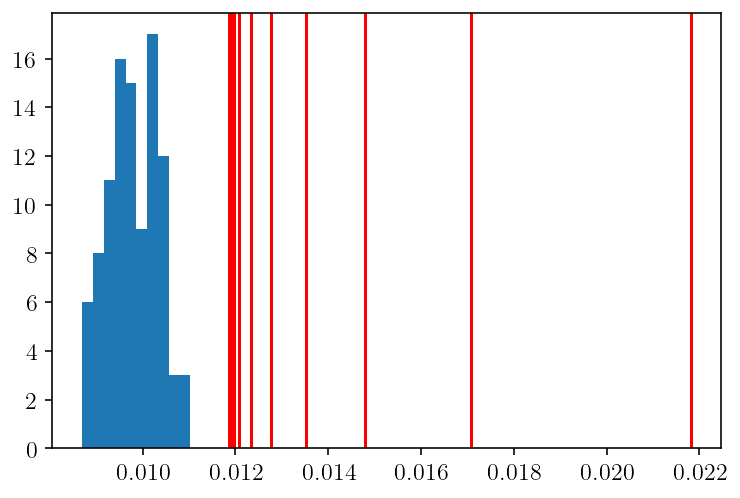

In [18]:
plt.hist(grad_est)
for i in range(len(grad_bound)):
    plt.axvline(grad_bound[i], color="r")
plt.show()